In [13]:
import warnings
from statsbombpy.api_client import NoAuthWarning
warnings.simplefilter('ignore', NoAuthWarning)
from socceraction.data.statsbomb import StatsBombLoader

api = StatsBombLoader(getter="remote", creds={"user": "", "passwd": ""})

In [14]:
import random

df_competitions = api.competitions()
random_row = df_competitions.sample(1)

competition_id = random_row['competition_id'].item()
season_id = random_row['season_id'].item()
competition_name = random_row['competition_name'].item()
season_name = random_row['season_name'].item()

df_games = api.games(competition_id=competition_id, season_id=season_id)

all_teams = list(df_games['home_team_id'].unique())
team_id = random.choice(all_teams)

df_games = df_games[(df_games['away_team_id'] == team_id) | (df_games['home_team_id'] == team_id)]
all_games = list(df_games['game_id'])
g = random.choice(all_games)

c_stage = df_games[df_games['game_id'] == g]['competition_stage'].item()
df_teams = api.teams(game_id=g)
df_players = api.players(game_id=g)
df_events = api.events(game_id=g)
team_name = df_events[df_events['team_id'] == team_id]['team_name'].iloc[0]
teams = list(df_events['team_name'].unique())
teams.remove(team_name)

c_string = f"{team_name} vs {teams[0]} ({competition_name} {c_stage} - {season_name})"

In [15]:
import matplotsoccer
import socceraction.spadl as spadl

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

def plot_highlight(goal_id, df_actions):
    df = df_actions[goal_id-10:goal_id+1].copy().reset_index(drop=True)

    opponent_df = df[df['team_name'] != df['team_name'].iloc[len(df)-1]]

    if opponent_df.empty:
        df = df[0:]
    else:
        last_row = opponent_df.index[-1]+1
        df = df[last_row:]

    if len(df) > 3:
        df["nice_time"] = df.apply(nice_time, axis=1)
        labels = df[["nice_time", "type_name", "player_name", "team_name"]]

        ax = matplotsoccer.actions(
            location=df[["start_x", "start_y", "end_x", "end_y"]],
            action_type=df.type_name,
            team=df.team_name,
            result= df.result_name == "success",
            label=labels,
            labeltitle=["time", "actiontype", "player", "team"],
            zoom=False,
            figsize=6
        )

def find_high_xg(df):
    df = df[df['xg'] > 0.1]
    return df.index

Bayern Munich vs Chelsea (Champions League Final - 2011/2012)


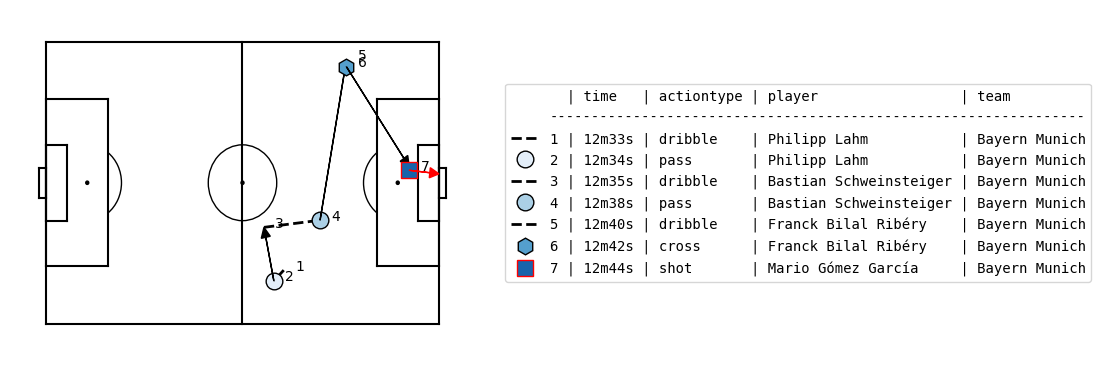

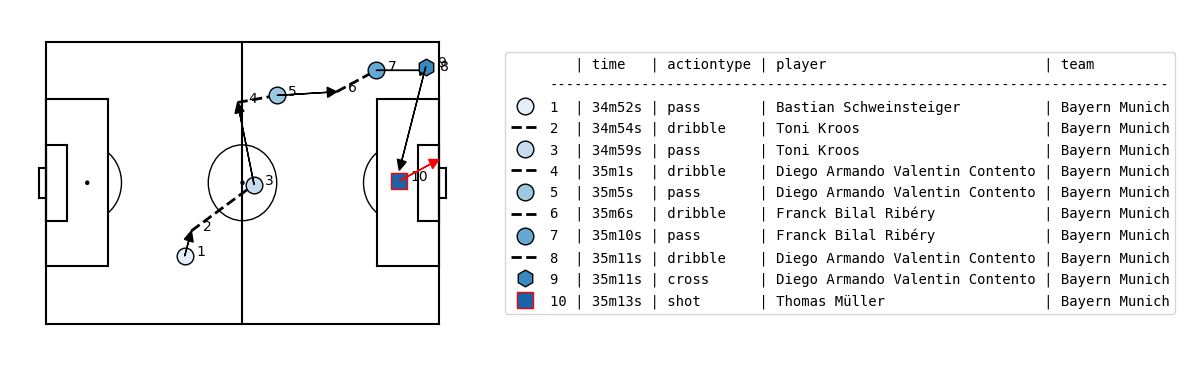

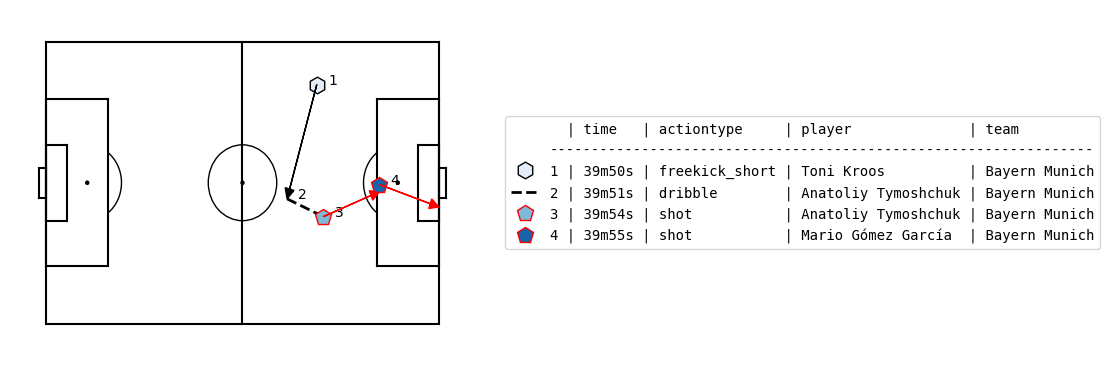

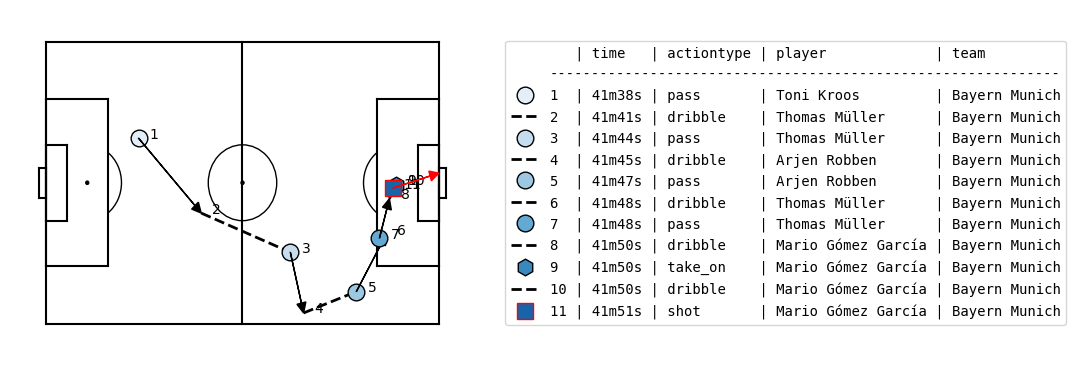

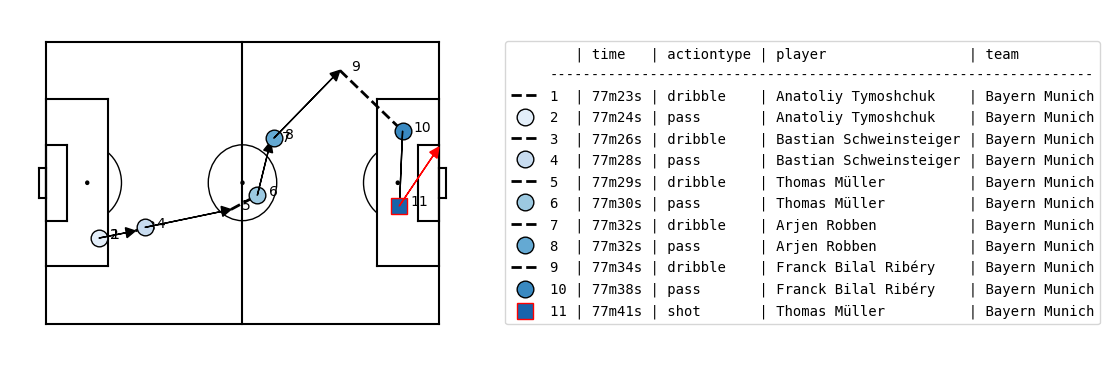

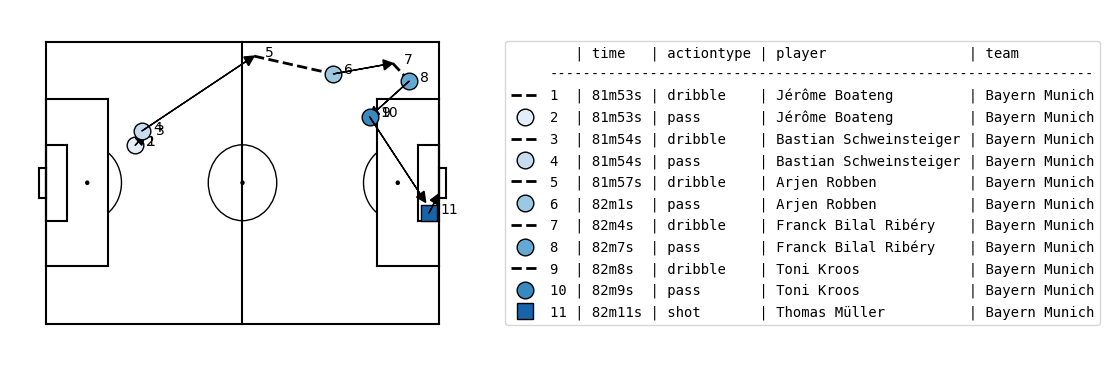

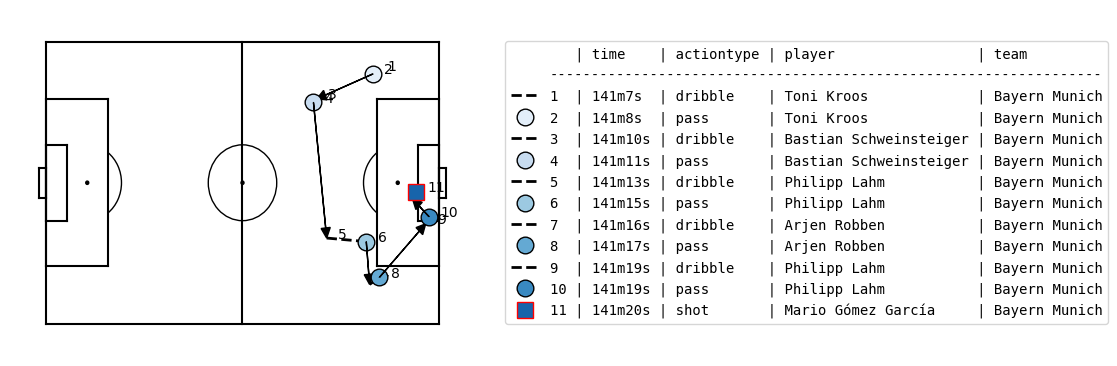

In [16]:
df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=team_id)
df_actions = (
spadl
.add_names(df_actions)
.merge(api.teams(game_id=g))
.merge(api.players(game_id=g))
)
df_actions = df_actions.sort_values(by=['period_id', 'time_seconds'], ascending=[True, True])
df_actions = df_actions.rename(columns={'original_event_id': 'event_id'})
print(c_string)

df_shots = df_events[df_events['type_name'] == 'Shot'].copy()
df_shots['xg'] = df_shots['extra'].apply(lambda x: x.get('shot', {}).get('statsbomb_xg'))
df_shots = df_shots[['event_id', 'xg']]

merged_df = df_actions.merge(df_shots, on='event_id', how='left').fillna(0)

ids = find_high_xg(merged_df)

for id in ids:
    plot_highlight(id, df_actions)